In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,7)

Lets start by adding some building blocks. I will have the most basic component being a class for handling layers. It should be able to process input aswell as propagate gradients through itself by the chain rule.

In [2]:
class Layer:
    """
    Building block. Can process input to get output and
    propagate gradients through itself. 
    
    Arguments
    ---------
    sizes: list. First entry should be the # of variables in X, last entry 
        should be the number of classes to predict. 
    """
    def __init__(self,):
        pass

    def forward(self, input):
        """
        Dummy layer, takes input of shape [batch, input_units] returns
        [batch, output_units]
        """
        return input
    
    def backward(self, input, grad_output):
        """
        Performs backprop stap through layer wrt given input
        """
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

Next, I will add classes for dealing with layers using the sigmoid and relu function.

In [3]:
class ReLU(Layer):
    """
    Forward and backpropagation for relu function
    """
    def __init__(self):
        pass
    
    def forward(self, input):
        relu_forward = np.maximum(0, input)
        return relu_forward
    
    def backward(self, input, grad_output):
        # computes the gradient of cross entropy loss
        # wrt relu input
        relu_grad = input > 0
        # hadamard prod
        return grad_output * relu_grad

class Sigmoid(Layer):
    """
    Forward and backpropagation for the sigmoid function
    """
    def __init__(self):
        pass
    
    def forward(self, input):
        sigmoid_forward = 1/(1+np.exp(-input))
        return sigmoid_forward
    
    def backward(self, input, grad_output):
        h = self.forward(input)
        sigmoid_grad = h * (1 - h)
        # hadamard prod
        return grad_output * sigmoid_grad

Next, a class for dealing with a fully connected layer will be considered. This class initializes the parameters and updates them in the backwards pass. 

In [23]:
class ConnectedLayer(Layer):
    """
    Applies the affine transformation
    """
    def __init__(self, input_units, output_units, step_size = 0.01):
        """
        """
        self.step_size = step_size
        self.weights = np.random.normal(loc = 0, scale = .01,
                                       size = (input_units, output_units))
        self.offsets = np.zeros(output_units)
    
    def forward(self, input):
        """
        Perform affine transformation
        """
        return input.dot(self.weights) + self.offsets
    
    def backward(self, input, grad_output):
        """
        Calculates the necessary components in the backprop pseudo-code
        outlined in L3
        """
        grad_input = grad_output.dot(self.weights.T)
        grad_weights = input.T.dot(grad_output)
        grad_offsets = grad_output.mean(axis = 0) * input.shape[0]
        
        # make sure nothing has gone wrong
        assert grad_weights.shape == self.weights.shape, \
            "grad_weights.shape = {}, weights.shape = {}".format(
            grad_weights.shape, self.weights.shape)
        
        assert grad_offsets.shape == self.offsets.shape, \
            "grad_offsets.shape = {}, offsets.shape = {}".format(
            grad_offsets.shape, self.offsets.shape)
        
        # update parameters
        self.weights -= self.step_size * grad_weights
        self.offsets -= self.step_size * grad_offsets
        
        return grad_input

In [24]:
def softmax(z):
    """
    Uses stabilization by subtracting the max in the exponent
    """
    s = np.max(z, axis=1).reshape(z.shape[0], 1)
    e_x = np.exp(z - s)
    return e_x / np.sum(e_x, axis=1).reshape(z.shape[0], 1)

def softmax_loss(z, y):
    """
    Computes the cross entropy loss
    """
    probs = softmax(z)
    return (-1 / y.shape[0]) * np.sum(y * np.log(probs))

def grad_softmax_loss(z, y):
    probs = softmax(z)
    return (probs - y) / z.shape[0]

Testing out the stuff

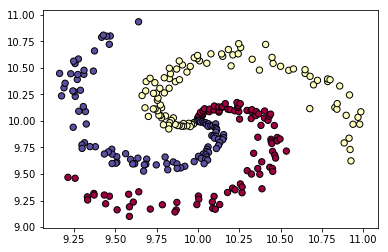

In [6]:
# Test using following
# http://cs231n.github.io/neural-networks-case-study/
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data:
X += 10
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral,
           edgecolors='black')
plt.show()

y = np.eye(np.max(y) + 1)[y]

For the test run with the simulated data, I will consider two layers, with the first having the relu activation faction with 50 nodes and the second having a sigmoid activation function with 100 nodes. 

In [7]:
def forward(network, X):
    """
    Forward propagation
    """
    activations = []
    input = X
    
    for l in network:
        activations.append(l.forward(input))
        input = activations[-1]
    
    assert len(activations) == len(network), \
        "len(activations) = {}, len(network) = {}".format(
        len(activations), len(network))
    
    return activations

def predict(network, X):
    """
    Output from the network
    """
    logits = forward(network, X)[-1]
    probs = softmax(logits)
    return probs.argmax(axis = 1)

def train(network, X, y):
    """
    Trains the network for a given batch.
    """
    # get layer activations
    layer_activations = forward(network, X)
    layer_inputs = [X] + layer_activations
    logits = layer_activations[-1]
    
    # loss and the softmax gradient (first exercise)
    loss = softmax_loss(logits, y)
    loss_grad = grad_softmax_loss(logits, y)
    
    # backpropagation through the network
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        loss_grad = layer.backward(layer_inputs[layer_index], loss_grad)
        
    return np.mean(loss)

In [8]:
def shuffle_data(X, y, batch_size = 10):
    """
    Shuffles X and y
    
    Returns: a list of tuples [(X, y)]
    """
    assert X.shape[0] == y.shape[0]
    batch_list = []
    row_permut = np.random.permutation(X.shape[0])
    row_permut_split = np.array_split(
        row_permut, np.round(X.shape[0]/batch_size))
        
    for batches in row_permut_split:
        batch_list.append((X[batches, :], y[batches, :]))
        
    return batch_list

In [25]:
network = []
network.append(ConnectedLayer(X.shape[1], 50))
network.append(ReLU())
# network.append(ConnectedLayer(50, 100))
# network.append(ReLU())
network.append(ConnectedLayer(50, y.shape[1]))

In [26]:
from IPython.display import clear_output
train_log = []
loss_log = []

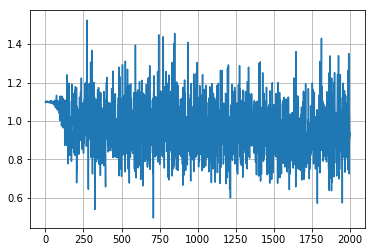

In [29]:
for epoch in range(1000):
    for batch in shuffle_data(X, y):
        loss = train(network, batch[0], batch[1])
        
    train_log.append(np.mean(predict(network, X) == np.argmax(y, axis  = 1)))
    loss_log.append(loss)
    
    # clear_output()
    # if epoch % 100 == 0:
    #    print("Train accuracy epoch {}: {}".format(epoch, train_log[-1]))
    
plt.plot(train_log)
plt.grid()
plt.show()

In [30]:
np.mean(predict(network, X) == np.argmax(y, axis = 1))

0.63

In [19]:
forward(network, X)[-1]

array([[ 0.00831638,  0.02696447, -0.03528084],
       [ 0.00831638,  0.02696447, -0.03528084],
       [ 0.00831638,  0.02696447, -0.03528084],
       [ 0.00831638,  0.02696447, -0.03528084],
       [ 0.00831638,  0.02696447, -0.03528084],
       [ 0.00831638,  0.02696447, -0.03528084],
       [ 0.00831638,  0.02696447, -0.03528084],
       [ 0.00831638,  0.02696447, -0.03528084],
       [ 0.00831638,  0.02696447, -0.03528084],
       [ 0.00831638,  0.02696447, -0.03528084],
       [ 0.00831638,  0.02696447, -0.03528084],
       [ 0.00831638,  0.02696447, -0.03528084],
       [ 0.00831638,  0.02696447, -0.03528084],
       [ 0.00831638,  0.02696447, -0.03528084],
       [ 0.00831638,  0.02696447, -0.03528084],
       [ 0.00831638,  0.02696447, -0.03528084],
       [ 0.00831638,  0.02696447, -0.03528084],
       [ 0.00831638,  0.02696447, -0.03528084],
       [ 0.00831638,  0.02696447, -0.03528084],
       [ 0.00831638,  0.02696447, -0.03528084],
       [ 0.00831638,  0.02696447, -0.035

In [13]:
from scipy import misc
import glob
import os
def load_mnist(path_to_MNIST):
    # Loads the MNIST dataset from png images
    NUM_LABELS = 10        
    # create list of image objects
    test_images = []
    test_labels = []    
    
    for label in range(NUM_LABELS):
        # the + str(label) didnt work for me
        for image_path in glob.glob(os.path.join(path_to_MNIST, "MNIST\\Test", str(label) + "\\*.png")):
            image = misc.imread(image_path)
            test_images.append(image)
            letter = [0 for _ in range(0,NUM_LABELS)]    
            letter[label] = 1
            test_labels.append(letter)  
            
    # create list of image objects
    train_images = []
    train_labels = []    
    
    for label in range(NUM_LABELS):
        for image_path in glob.glob(os.path.join(path_to_MNIST, "MNIST\\Train", str(label) + "\\*.png")):
            image = misc.imread(image_path)
            train_images.append(image)
            letter = [0 for _ in range(0,NUM_LABELS)]    
            letter[label] = 1
            train_labels.append(letter)                  
            
    X_train= np.array(train_images).reshape(-1,784)/255.0
    Y_train= np.array(train_labels)
    X_test= np.array(test_images).reshape(-1,784)/255.0
    Y_test= np.array(test_labels)
    
    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = load_mnist("C:\\Users\\lukar818\\Desktop")

C:\Users\lukar818\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\Users\lukar818\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


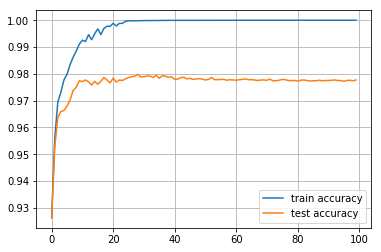

In [14]:
network = []
network.append(ConnectedLayer(X_train.shape[1], 50))
network.append(ReLU())
network.append(ConnectedLayer(50, 100))
network.append(Sigmoid())
network.append(ConnectedLayer(100, Y_train.shape[1]))

train_MNIST_log = []
test_MNIST_log = []


for epoch in range(100):
    for batch in shuffle_data(X_train, Y_train):
        loss = train(network, batch[0], batch[1])
        
    train_MNIST_log.append(np.mean(predict(network, X_train) == np.argmax(Y_train, axis  = 1)))
    test_MNIST_log.append(np.mean(predict(network, X_test) == np.argmax(Y_test, axis = 1)))
    
    # clear_output()
    # if epoch % 100 == 0:
    #    print("Train accuracy epoch {}: {}".format(epoch, train_log[-1]))
    
plt.plot(train_MNIST_log, label = "train accuracy")
plt.plot(test_MNIST_log, label = "test accuracy")
plt.legend(loc = "best")
plt.grid()
plt.show()

In [15]:
np.mean(predict(network, X_test) == np.argmax(Y_test, axis = 1))

0.9777